In [1]:
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
from preisach import models, transducer
from instruments import yoko7651
from instruments import zvk
import datetime
import time

reload(zvk)
reload(yoko7651)
reload(models)
reload(transducer)

%cd C:\Users\etudiant.jeip\Documents\tunable-filter\preisach\

C:\Users\etudiant.jeip\Documents\tunable-filter\preisach


# Verifying validity of Preisach model for the YIG filter
## 1. a few functions

In [2]:
def get_max_peaks(amps, f_list):
    if f_list.ndim == 1 : 
        v_shape, _ = amps.shape
        max_freqs = np.zeros(v_shape)
        max_values = np.zeros(v_shape)
        for i in range(v_shape) :
            v_slice = amps[i, :]
            max_freqs[i] = f_list[np.argmax(v_slice)]
            max_values[i] = np.max(v_slice)
        return max_freqs, max_values
    
    elif f_list.ndim == 2:
        v_shape, _ = amps.shape
        max_freqs = np.zeros(v_shape)
        max_values = np.zeros(v_shape)
        for i in range(v_shape) :
            v_slice = amps[i, :]
            max_freqs[i] = f_list[i, np.argmax(v_slice)]
            max_values[i] = np.max(v_slice)
        return max_freqs, max_values
    else : raise ValueError("f_list must have one or two dims.")

def get_band_pass_position(amps_dB, f_list, cutoff = 3):
    if f_list.ndim == 1 : 
        v_shape, _ = amps_dB.shape
        band_freqs = np.zeros((v_shape, 2))
        max_values = np.zeros(v_shape)
        for i in range(v_shape) :
            v_slice = amps_dB[i, :]
            max_val = np.max(v_slice)
            max_values[i] = max_val
            pass_band = np.nonzero(v_slice >= (max_val - cutoff)) # get indices of values that are less that 3dB from plateau value
            band_freqs[i, :] = f_list[np.min(pass_band)], f_list[np.max(pass_band)]
        return band_freqs, max_values
    
    elif f_list.ndim == 2:
        v_shape, _ = amps_dB.shape
        band_freqs = np.zeros((v_shape, 2))
        max_values = np.zeros(v_shape)
        for i in range(v_shape) :
            v_slice = amps_dB[i, :]
            max_val = np.max(v_slice)
            max_values[i] = max_val
            pass_band = np.nonzero(v_slice >= (max_val - cutoff)) # get indices of values that are less that 3dB from plateau value
            band_freqs[i, :] = f_list[i, np.min(pass_band)], f_list[i, np.max(pass_band)]
        return band_freqs, max_values
    else : raise ValueError("f_list must have one or two dims.")
    
def get_band_pass_single_trace(amps_dB, f_list, cutoff = 3):
    max_val = np.max(amps_dB)
    pass_band = np.nonzero(amps_dB >= (max_val - cutoff)) # get indices of values that are less that 3dB from plateau value
    band_freqs = f_list[np.min(pass_band)], f_list[np.max(pass_band)]
    return band_freqs, max_val

def theoretical_peak_position(V):
    return (38e9/10)*V + 2e9

def freq_window(V, delta):
    """Gives the freq window to give  to the VNA for input voltage V and window width delta (delta in Hz)"""
    if V <= (10/38e9)*(40e9 - 2e9 - delta/2) :
        return np.array([-delta/2, delta/2]) + (38e9/10)*V + 2e9
    else : 
        return np.array([40e9 - delta, 40e9])
    
def ramp_yoko(voltage, delay):
    global CURRENT_YOKO_VOLTAGE
    delta_v = abs(voltage - CURRENT_YOKO_VOLTAGE)
    if delta_v != 0 :
        delta_t = round(delay, 1)
        print(f"GOING TO VOLTAGE {voltage:.1f}, deltaV = {delta_v:.1f} V, delta_t = {delta_t:.1f} s")
        yoko.interval(delta_t)
        yoko.sweep_duration(delta_t)

        with yoko.write_program() as program : 
            program.source_voltage()
            program.range_voltage(12)
            program.voltage(voltage)
        
        yoko.run_program()
        time.sleep(delta_t + 1) # adding one milli second to make sure filter stabilizes

    CURRENT_YOKO_VOLTAGE = voltage
    return None

## Loading data and correcting a mistake I made
(all data before jul 25, 2022 has V_values with wrong values (reversed ?). Just need to re-generate it.)

In [15]:
measurement = "preisach_triangle20220727-10h36min28s.npz" # 201² points

#measurement = "preisach_triangle20220726-15h27min49s.npz"

with np.load(measurement, allow_pickle = True) as npzfile:
    zvk_traces = npzfile["zvk_traces"]
    zvk_freqs = npzfile["zvk_freqs"]
    V_values = npzfile["V_values"]
    indices = npzfile["indices"]
    center_freqs = npzfile["center_freqs"]*1e9
    meta = npzfile['meta'].item()

#V_values = np.linspace(0, 10, V_values.shape[0])

V_history = V_values[indices]

## Setting up model and trying to see if it really does predict well
### Setting up model, instruments, etc

In [16]:
reload(models)
N_total_points = 501
model = models.Preisach(V_history, center_freqs)

T = np.linspace(0, 6, N_total_points)
X = 5*(-np.cos(10*T)*np.exp(-T) + 1)

model_outputs = np.zeros(N_total_points)

for i, V in enumerate(X):
    model_outputs[i] = model.to_value(V)

In [5]:

# -------------------- PARAMETERS
PATH = r"C:\Users\etudiant.jeip\Documents\tunable-filter\preisach"

SMALLEST_STEP_RAMP_TIME = 0.1 # Yoko only allows sweeps to last for 0.1 to 3600 s, with a resolution of 0.1s . 
N_FREQ_SWEEP_POINTS = 401 # number of steps for VNA freq sweeps
VNA_WINDOW_WIDTH = 100e6
TRACENAME = "CH1DATA"
FILENAME = r'\preisach_verif\measured_demag'
N_total_points = len(X)


# Inferring some variables from parameters



# -------------------- INSTRUMENT SETUP
vna = zvk.Zvk("GPIB0::20::INSTR")
yoko = yoko7651.Yoko7651("GPIB0::16::INSTR")

vna.sweep_points = N_FREQ_SWEEP_POINTS
vna.power = -15 #dBm
vna.averaging = 0
vna.sweep_count = 1
vna.bandwidth = 10e3
VNA_SWEEP_DUR = 1.1*vna.sweep_duration
vna.single_sweep = True


zvk_freqs_verif = np.zeros((N_total_points, N_FREQ_SWEEP_POINTS))
zvk_traces_verif = np.zeros((N_total_points, N_FREQ_SWEEP_POINTS), dtype = "complex")
center_freqs_verif = np.zeros_like(model_outputs)


Instrument initialized.
VISA resource: GPIB0::20::INSTR
Instrument initialized.
VISA resource: GPIB0::16::INSTR


### Running measurement

In [6]:
SAVE_FILE = False
CURRENT_YOKO_VOLTAGE = 10
ramp_yoko(0, 10)

when = datetime.datetime.now()
filename_final = input(f'Filename ? (or Enter to cancel, or Space+Enter for {FILENAME}): ')
if filename_final == '':
    del vna
    del yoko
    print("measurement cancelled.")
    quit()

filename_final = FILENAME + when.strftime('%Y%m%d-%Hh%Mmin%Ss')

for i, V in enumerate(X): 
    
    freq_limits = freq_window(V, VNA_WINDOW_WIDTH)
    vna.freq_start_stop = freq_limits

    ramp_yoko(V, 0.1)
    time.sleep(0.02)
    vna.trigger()

    while vna.busy() :
        time.sleep(0.01)

    f, z = vna.get_data(trace = TRACENAME)

    while vna.busy() :
        time.sleep(0.01)
    
    zvk_traces_verif[i, :] = z
    zvk_freqs_verif[i, :] = f


zvk_traces_dB_verif = 20*np.log10(np.abs(zvk_traces_verif))

band_freqs_verif, max_values_verif = get_band_pass_position(zvk_traces_dB_verif, zvk_freqs_verif)

center_freqs_verif = np.mean(band_freqs_verif, axis = -1)

if SAVE_FILE:
    np.savez(PATH + filename_final, zvk_traces = zvk_traces_verif, zvk_freqs = zvk_freqs_verif, X = X)

ramp_yoko(0, 10)

GOING TO VOLTAGE 0.0, deltaV = 10.0 V, delta_t = 10.0 s
Starting to write program...
Finishing program writing.


Filename ? (or Enter to cancel, or Space+Enter for \preisach_verif\measured_demag):   


GOING TO VOLTAGE 0.1, deltaV = 0.1 V, delta_t = 0.1 s
Starting to write program...
Finishing program writing.
GOING TO VOLTAGE 0.3, deltaV = 0.2 V, delta_t = 0.1 s
Starting to write program...
Finishing program writing.
GOING TO VOLTAGE 0.5, deltaV = 0.2 V, delta_t = 0.1 s
Starting to write program...
Finishing program writing.
GOING TO VOLTAGE 0.8, deltaV = 0.3 V, delta_t = 0.1 s
Starting to write program...
Finishing program writing.
GOING TO VOLTAGE 1.1, deltaV = 0.3 V, delta_t = 0.1 s
Starting to write program...
Finishing program writing.
GOING TO VOLTAGE 1.5, deltaV = 0.4 V, delta_t = 0.1 s
Starting to write program...
Finishing program writing.
GOING TO VOLTAGE 1.9, deltaV = 0.4 V, delta_t = 0.1 s
Starting to write program...
Finishing program writing.
GOING TO VOLTAGE 2.4, deltaV = 0.5 V, delta_t = 0.1 s
Starting to write program...
Finishing program writing.
GOING TO VOLTAGE 2.9, deltaV = 0.5 V, delta_t = 0.1 s
Starting to write program...
Finishing program writing.
GOING TO V

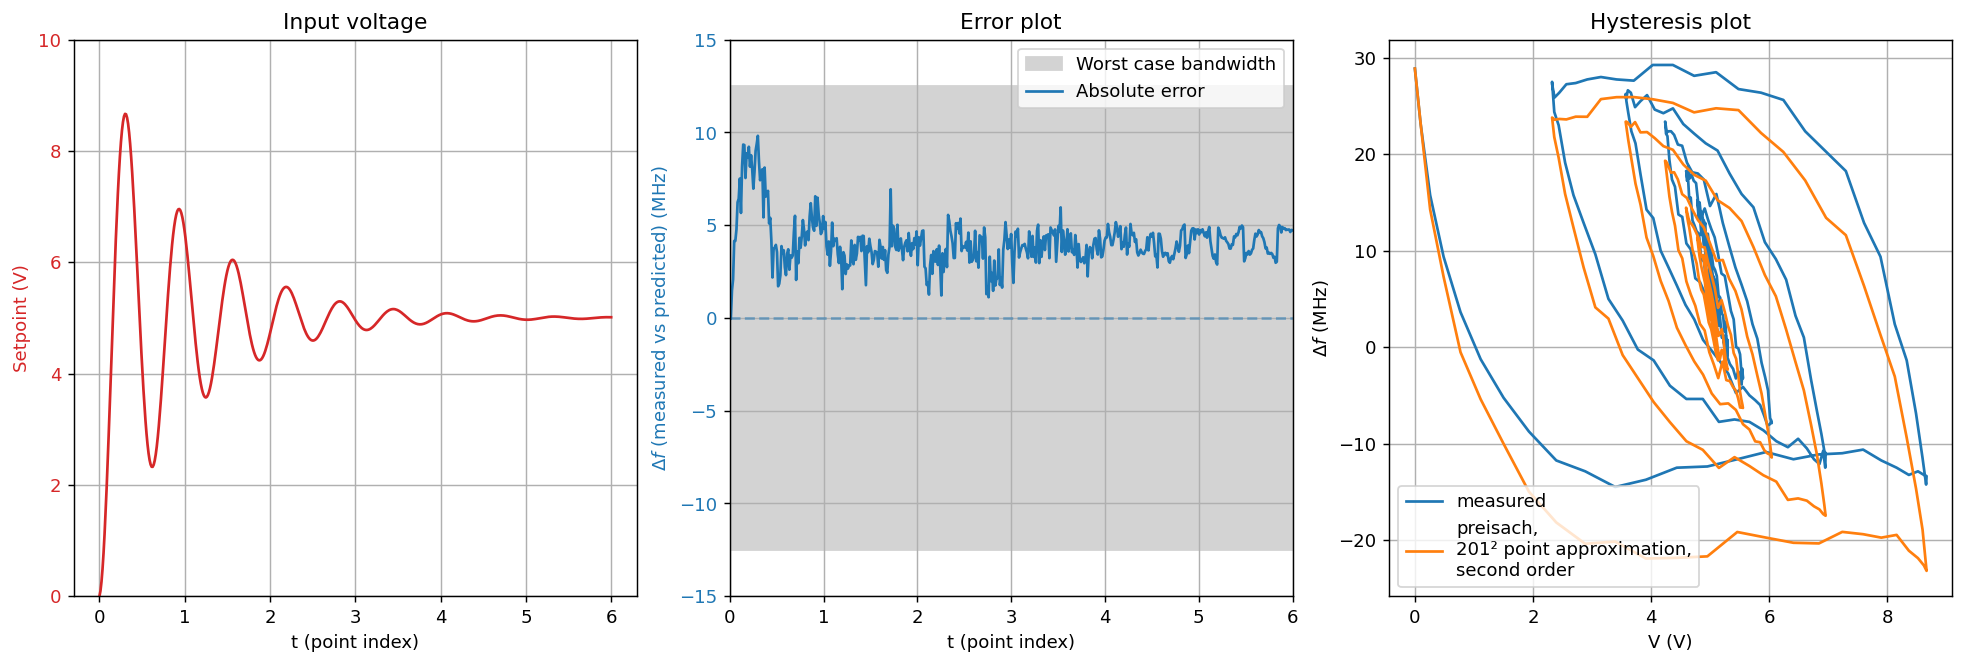

In [17]:

center_freqs_verif = np.mean(band_freqs_verif, axis = -1)
Y = theoretical_peak_position(X)

fig, ax = plt.subplots(1, 3, figsize = (15, 5), dpi = 130, constrained_layout = True)

ax_g, ax_r, ax_l = ax

#ax_g = ax_r.twinx()

ax_l.grid(True)
ax_r.grid(True)
ax_g.grid(True)

ax_g.plot(T, X, color = 'tab:red', label = 'Voltage')

ax_l.plot(X, (center_freqs_verif - theoretical_peak_position(X))/1e6, label = 'measured')
ax_l.plot(X, (model_outputs - theoretical_peak_position(X))/1e6, label = 'preisach,\n201² point approximation,\nsecond order')
ax_l.legend()

ax_r.fill_between(T, -12.5, 12.5, color = 'lightgray', label = 'Worst case bandwidth')
ax_r.plot(T, (center_freqs_verif - model_outputs)/1e6, color = 'tab:blue', label = 'Absolute error')
ax_r.legend()

ax_l.set_xlabel("V (V)")
ax_l.set_ylabel(r"$\Delta f$ (MHz)")

ax_r.set_xlabel("t (point index)")
ax_r.set_ylabel(r"$\Delta f$ (measured vs predicted) (MHz)", color = 'tab:blue')
ax_r.axhline(color = 'tab:blue', linestyle = '--', alpha = 0.5)
ax_r.tick_params(axis='y', labelcolor='tab:blue')

ax_r.set_xlim(0, 6)
ax_r.set_ylim(-15, 15)

ax_g.set_ylabel("Setpoint (V)", color = 'tab:red')
ax_g.set_xlabel("t (point index)")
ax_g.set_ylim(0, 10)
ax_g.tick_params(axis='y', labelcolor='tab:red')


ax_l.set_title("Hysteresis plot")
ax_r.set_title("Error plot")
ax_g.set_title("Input voltage")

if False:
    fig.savefig(r"preisach_verif/v2.png")

In [8]:
center_freqs_verif

array([2.02887501e+09, 2.38489344e+09, 2.99798579e+09, 3.85610304e+09,
       4.94055347e+09, 6.23058560e+09, 7.70275917e+09, 9.33121280e+09,
       1.10888269e+10, 1.29486556e+10, 1.48792325e+10, 1.68540099e+10,
       1.88417864e+10, 2.08121283e+10, 2.27388897e+10, 2.45948529e+10,
       2.63535657e+10, 2.79947960e+10, 2.94961818e+10, 3.08401101e+10,
       3.20092846e+10, 3.29928909e+10, 3.37808364e+10, 3.43675628e+10,
       3.47475804e+10, 3.49213102e+10, 3.48901581e+10, 3.46637701e+10,
       3.42484060e+10, 3.36536166e+10, 3.28896707e+10, 3.19765555e+10,
       3.09243443e+10, 2.97567785e+10, 2.84882258e+10, 2.71427369e+10,
       2.57424824e+10, 2.43053087e+10, 2.28547942e+10, 2.14138225e+10,
       1.99994102e+10, 1.86347950e+10, 1.73358100e+10, 1.61190200e+10,
       1.50032512e+10, 1.40005427e+10, 1.31219871e+10, 1.23776097e+10,
       1.17752796e+10, 1.13192781e+10, 1.10137748e+10, 1.08610883e+10,
       1.08568494e+10, 1.09953254e+10, 1.12761452e+10, 1.16876744e+10,
      

In [9]:
del yoko
del vna

VISA instrument released (GPIB0::16::INSTR).
VISA instrument released (GPIB0::20::INSTR).
